In [ ]:
!git clone https://github.com/openai/CLIP.git
%cd /content/CLIP
!pip install ftfy
import clip
%cd /content

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Total 256 (delta 0), reused 0 (delta 0), pack-reused 256 (from 1)
Receiving objects: 100% (256/256), 8.87 MiB | 12.65 MiB/s, done.
Resolving deltas: 100% (136/136), done.
/content/CLIP
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
/content


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import os
import clip
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

class CharacterDataset(Dataset):
    """
    Converts CSV data into text-image pairs using CLIP embeddings.
    Matches character names from CSV to image filenames.
    """
    def __init__(self, csv_file=None, clip_model=None, clip_preprocess=None, device=None,
                 image_dir=None, base_prompt="Genshin-style character", encoding='utf-8'):
        """
        Args:
            csv_file: Path to CSV with character data (must have 'character_name' column)
            clip_model: Pre-trained CLIP model for encoding
            clip_preprocess: CLIP preprocessing function for images
            device: torch device
            image_dir: Directory containing character images (e.g., "Albedo.png")
            base_prompt: Base text prompt (e.g., "Genshin-style character")
            encoding: CSV file encoding
        """
        self.clip_model = clip_model
        self.clip_preprocess = clip_preprocess
        self.device = device
        self.base_prompt = base_prompt
        self.image_dir = image_dir

        # Hard-coded Google Drive paths
        if csv_file is None:
            csv_file = "/content/drive/MyDrive/filtered_output.csv"
        if image_dir is None:
            image_dir = "/content/drive/MyDrive/characters/"

        print(f"Loading CSV from: {csv_file}")
        print(f"Looking for images in: {image_dir}")

        # Read CSV with multiple encoding attempts
        encodings_to_try = [encoding, 'latin-1', 'iso-8859-1', 'cp1252']

        for enc in encodings_to_try:
            try:
                self.df = pd.read_csv(csv_file, encoding=enc)
                print(f"✓ Successfully loaded CSV with encoding: {enc}")
                break
            except UnicodeDecodeError:
                if enc == encodings_to_try[-1]:
                    raise
                continue
            except FileNotFoundError:
                raise FileNotFoundError(f"CSV file not found at: {csv_file}\nPlease check the path in Google Drive.")

        # Verify character_name column exists
        if 'character_name' not in self.df.columns:
            raise ValueError(f"CSV must have 'character_name' column. Found: {list(self.df.columns)}")

        print(f"Loaded {len(self.df)} characters from CSV")
        print(f"Columns: {list(self.df.columns)}")

        # Define the string columns that go through CLIP encoding
        self.string_columns = ['character_name', 'constellation', 'affiliation']

        # Define categorical columns
        self.categorical_columns = ['region', 'vision', 'weapon_type', 'body_figure']

        # Build categorical mappings
        self.cat_mappings = {}
        for col in self.categorical_columns:
            if col in self.df.columns:
                unique_values = self.df[col].unique()
                self.cat_mappings[col] = {val: idx for idx, val in enumerate(unique_values)}
                print(f"{col}: {len(unique_values)} unique values - {unique_values}")

        # Find matching images for each character
        print("\n" + "="*60)
        print("MATCHING CHARACTER NAMES TO IMAGE FILES")
        print("="*60)
        self._match_images_to_characters()

        # Pre-compute base text embedding
        print(f"\nPre-computing base text embedding for: '{self.base_prompt}'")
        with torch.no_grad():
            base_token = clip.tokenize([self.base_prompt], truncate=True).to(device)
            self.base_text_embed = self.clip_model.encode_text(base_token)
            self.base_text_embed = self.base_text_embed / self.base_text_embed.norm(dim=-1, keepdim=True)
            self.base_text_embed = self.base_text_embed.cpu()

        # Pre-compute CLIP embeddings for string inputs
        print("\nPre-computing CLIP TEXT embeddings for character attributes...")
        self._precompute_text_embeddings()

        # Pre-compute target CLIP IMAGE embeddings
        print("\nPre-computing target CLIP IMAGE embeddings...")
        self._precompute_image_embeddings()

        # Convert categorical columns to indices
        if self.categorical_columns:
            self.categorical_indices = torch.zeros((len(self.df), len(self.categorical_columns)), dtype=torch.long)
            for i, col in enumerate(self.categorical_columns):
                if col in self.df.columns:
                    self.categorical_indices[:, i] = torch.tensor([
                        self.cat_mappings[col][val] for val in self.df[col]
                    ])

        print(f"\n{'='*60}")
        print(f"✓ Dataset ready with {len(self)} samples")
        print(f"{'='*60}\n")

    def _match_images_to_characters(self):
        """
        Match character names from CSV to image filenames.
        Handles spaces, underscores, and case-insensitive matching.
        """
        # Get all image files in the directory
        if not os.path.exists(self.image_dir):
            raise FileNotFoundError(f"Image directory not found: {self.image_dir}")

        image_files = [f for f in os.listdir(self.image_dir)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]

        print(f"Found {len(image_files)} image files in directory")

        # Create mapping of normalized names to actual filenames
        image_map = {}
        for img_file in image_files:
            # Remove extension and normalize
            name_without_ext = os.path.splitext(img_file)[0]
            normalized = name_without_ext.lower().replace('_', ' ').replace('-', ' ')
            image_map[normalized] = img_file

        # Match each character to an image
        self.df['image_path'] = None
        matched_count = 0

        for idx, row in self.df.iterrows():
            char_name = str(row['character_name'])

            # Try exact match first
            if char_name in image_map:
                self.df.at[idx, 'image_path'] = os.path.join(self.image_dir, image_map[char_name])
                matched_count += 1
                continue

            # Try normalized matching
            normalized_char = char_name.lower().replace('_', ' ').replace('-', ' ')
            if normalized_char in image_map:
                self.df.at[idx, 'image_path'] = os.path.join(self.image_dir, image_map[normalized_char])
                matched_count += 1
                print(f"✓ Matched '{char_name}' → '{image_map[normalized_char]}'")
            else:
                print(f"✗ WARNING: No image found for '{char_name}'")

        print(f"\nMatched {matched_count}/{len(self.df)} characters to images")

        # Filter out rows without images
        original_len = len(self.df)
        self.df = self.df[self.df['image_path'].notna()].reset_index(drop=True)
        if len(self.df) < original_len:
            print(f"Removed {original_len - len(self.df)} characters without images")

    def _precompute_text_embeddings(self):
        """Pre-compute CLIP text embeddings for character attributes"""
        self.string_embeds = []

        with torch.no_grad():
            for idx, row in tqdm(self.df.iterrows(), total=len(self.df), desc="Text embeddings"):
                # Get string values for each column that exists
                strings = []
                for col in self.string_columns:
                    if col in self.df.columns:
                        strings.append(str(row[col]))

                if strings:
                    # Tokenize and encode
                    tokens = clip.tokenize(strings, truncate=True).to(self.device)
                    embeds = self.clip_model.encode_text(tokens)
                    embeds = embeds / embeds.norm(dim=-1, keepdim=True)
                    self.string_embeds.append(embeds.cpu())
                else:
                    # Fallback if no string columns
                    self.string_embeds.append(torch.zeros(1, 512).cpu())

    def _precompute_image_embeddings(self):
        """Pre-compute CLIP image embeddings from character images"""
        self.target_image_embeds = []
        failed_images = []

        with torch.no_grad():
            for idx, row in tqdm(self.df.iterrows(), total=len(self.df), desc="Image embeddings"):
                img_path = row['image_path']

                try:
                    # Load and preprocess image
                    image = Image.open(img_path).convert('RGB')
                    image_input = self.clip_preprocess(image).unsqueeze(0).to(self.device)

                    # Encode image with CLIP
                    image_embed = self.clip_model.encode_image(image_input)
                    image_embed = image_embed / image_embed.norm(dim=-1, keepdim=True)

                    self.target_image_embeds.append(image_embed.cpu())

                except Exception as e:
                    failed_images.append((row['character_name'], str(e)))
                    # Use zero embedding as placeholder
                    self.target_image_embeds.append(torch.zeros(1, 512).cpu())

        if failed_images:
            print(f"\n⚠ Failed to load {len(failed_images)} images:")
            for name, error in failed_images[:5]:  # Show first 5
                print(f"  - {name}: {error}")

    def _create_text_description(self, row):
        """Create a natural language description from row data"""
        parts = [f"{row['character_name']}"]

        if 'rarity' in row:
            parts.append(f"is a {row['rarity']}-star")
        if 'vision' in row:
            parts.append(f"{row['vision']} character")
        if 'region' in row:
            parts.append(f"from {row['region']}")
        if 'weapon_type' in row:
            parts.append(f"who wields a {row['weapon_type']}")
        if 'body_figure' in row:
            parts.append(f"with a {row['body_figure']} body figure")
        if 'affiliation' in row:
            parts.append(f"and belongs to {row['affiliation']}")
        if 'constellation' in row:
            parts.append(f"Their constellation is {row['constellation']}")

        return " ".join(parts) + "."

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Returns:
            string_embeds: (N, embed_dim) - CLIP embeddings for textual attributes
            categorical_inputs: (M,) - indices for categorical inputs
            base_text_embed: (1, embed_dim) - base text embedding
            target_image_embed: (1, embed_dim) - target CLIP IMAGE embedding
        """
        return (
            self.string_embeds[idx],
            self.categorical_indices[idx] if hasattr(self, 'categorical_indices') else torch.tensor([]),
            self.base_text_embed,
            self.target_image_embeds[idx]
        )

    def get_num_categories(self):
        """Returns number of categories for each categorical column"""
        return [len(self.cat_mappings[col]) for col in self.categorical_columns if col in self.cat_mappings]

    def get_raw_data(self, idx):
        """Get the original row data for inspection"""
        return self.df.iloc[idx]

    def get_character_name(self, idx):
        """Get character name for a given index"""
        return self.df.iloc[idx]['character_name']

    def get_image_path(self, idx):
        """Get image path for a given index"""
        return self.df.iloc[idx]['image_path']


def create_train_val_split(dataset, val_ratio=0.2, random_seed=42):
    """Split dataset into training and validation sets"""
    dataset_size = len(dataset)
    indices = list(range(dataset_size))

    # Shuffle indices
    torch.manual_seed(random_seed)
    indices = torch.randperm(dataset_size).tolist()

    # Split
    split_idx = int(dataset_size * (1 - val_ratio))
    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]

    # Create subset datasets
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    return train_dataset, val_dataset


# Example usage
if __name__ == "__main__":
    # Load CLIP model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}\n")

    print("Loading CLIP model...")
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    clip_model.eval()
    print("✓ CLIP model loaded\n")

    # Create dataset
    # The paths will use the defaults specified in __init__ if not provided
    csv_file = "/content/drive/MyDrive/filtered_output.csv"
    image_dir = "/content/drive/MyDrive/characters/"

    dataset = CharacterDataset(
        csv_file=csv_file,
        clip_model=clip_model,
        clip_preprocess=clip_preprocess,
        device=device,
        image_dir=image_dir
    )

    # Check number of categories
    num_categories = dataset.get_num_categories()
    print(f"\nNumber of categories per column: {num_categories}")

    # Split into train/val
    train_dataset, val_dataset = create_train_val_split(dataset, val_ratio=0.2)
    print(f"\nTrain size: {len(train_dataset)}, Val size: {len(val_dataset)}")

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Test loading a batch
    print("\nTesting batch loading...")
    for string_embeds, cat_inputs, base_embed, target_images in train_loader:
        print(f"\nBatch shapes:")
        print(f"  String embeddings: {string_embeds.shape}")
        print(f"  Categorical inputs: {cat_inputs.shape}")
        print(f"  Base text embedding: {base_embed.shape}")
        print(f"  Target image embeddings: {target_images.shape}")
        break

    # Inspect first few samples
    print(f"\n{'='*60}")
    print("SAMPLE DATA INSPECTION")
    print(f"{'='*60}")
    for i in range(min(3, len(dataset))):
        print(f"\nSample {i}:")
        print(f"  Character: {dataset.get_character_name(i)}")
        print(f"  Image: {dataset.get_image_path(i)}")
        print(f"  Raw data: {dataset.get_raw_data(i).to_dict()}")

Mounted at /content/drive
Using device: cpu

Loading CLIP model...


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 103MiB/s]


✓ CLIP model loaded

Loading CSV from: /content/drive/MyDrive/filtered_output.csv
Looking for images in: /content/drive/MyDrive/characters/
✓ Successfully loaded CSV with encoding: utf-8
Loaded 73 characters from CSV
Columns: ['character_name', 'region', 'vision', 'weapon_type', 'body_figure', 'rarity', 'constellation', 'affiliation']
region: 6 unique values - ['Mondstadt' 'Sumeru' 'Inazuma' 'Liyue' 'Fontaine' 'Snezhnaya']
vision: 7 unique values - ['Geo' 'Dendro' 'Pyro' 'Hydro' 'Electro' 'Cryo' 'Anemo']
weapon_type: 5 unique values - ['Sword' 'Bow' 'Claymore' 'Catalyst' 'Polearm']
body_figure: 5 unique values - ['Medium Male' 'Tall Male' 'Medium Female' 'Tall Female' 'Short Female']

MATCHING CHARACTER NAMES TO IMAGE FILES
Found 106 image files in directory
✓ Matched 'Albedo' → 'Albedo.png'
✓ Matched 'Alhaitham' → 'Alhaitham.png'
✓ Matched 'Amber' → 'Amber.png'
✓ Matched 'Arataki Itto' → 'Arataki_Itto.png'
✓ Matched 'Baizhu' → 'Baizhu.png'
✓ Matched 'Barbara' → 'Barbara.png'
✓ Matched

Text embeddings: 100%|██████████| 73/73 [00:30<00:00,  2.36it/s]



Pre-computing target CLIP IMAGE embeddings...


Image embeddings:  66%|██████▌   | 48/73 [00:35<00:18,  1.34it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Image embeddings: 100%|██████████| 73/73 [00:54<00:00,  1.34it/s]


✓ Dataset ready with 73 samples


Number of categories per column: [6, 7, 5, 5]

Train size: 58, Val size: 15

Testing batch loading...

Batch shapes:
  String embeddings: torch.Size([16, 3, 512])
  Categorical inputs: torch.Size([16, 4])
  Base text embedding: torch.Size([16, 1, 512])
  Target image embeddings: torch.Size([16, 1, 512])

SAMPLE DATA INSPECTION

Sample 0:
  Character: Albedo
  Image: /content/drive/MyDrive/characters/Albedo.png
  Raw data: {'character_name': 'Albedo', 'region': 'Mondstadt', 'vision': 'Geo', 'weapon_type': 'Sword', 'body_figure': 'Medium Male', 'rarity': 5, 'constellation': 'Princeps Cretaceus', 'affiliation': 'Knights of Favonius', 'image_path': '/content/drive/MyDrive/characters/Albedo.png'}

Sample 1:
  Character: Alhaitham
  Image: /content/drive/MyDrive/characters/Alhaitham.png
  Raw data: {'character_name': 'Alhaitham', 'region': 'Sumeru', 'vision': 'Dendro', 'weapon_type': 'Sword', 'body_figure': 'Tall Male', 'rarity': 5, 'constellation': 'Vultur

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CLIPOffsetMLP(nn.Module):
    """
    MLP that predicts an offset in CLIP embedding space.
    Architecture: concatenated [one-hot vectors, CLIP text embeddings] -> MLP -> offset vector
    Final embedding: E_pred = E_base + E_offset
    """
    def __init__(
        self,
        clip_dim=512,  # CLIP embedding dimension (512 for ViT-B/32, 768 for ViT-L/14)
        string_embed_dim=512,  # dimension for string embeddings from CLIP
        num_categories_per_attr=[6, 7, 5, 5],  # number of categories for each discrete attribute
        num_text_attrs=3,  # number of textual attributes (character_name, constellation, affiliation)
        hidden_dims=[1024, 1024, 512],  # hidden layer dimensions
        normalize_inputs=True,  # normalize components before concatenation
        dropout=0.1,  # dropout rate
    ):
        super().__init__()

        self.clip_dim = clip_dim
        self.string_embed_dim = string_embed_dim
        self.num_text_attrs = num_text_attrs
        self.normalize_inputs = normalize_inputs

        # Handle case where no categorical attributes are provided
        if num_categories_per_attr is None or len(num_categories_per_attr) == 0:
            self.num_categories_per_attr = []
            total_onehot_dim = 0
        else:
            self.num_categories_per_attr = num_categories_per_attr
            total_onehot_dim = sum(num_categories_per_attr)

        # Calculate input dimensions
        total_text_dim = num_text_attrs * string_embed_dim

        # Total input dimension after concatenation
        input_dim = total_onehot_dim + total_text_dim

        print(f"\nModel Architecture:")
        print(f"  Input dimensions:")
        print(f"    - One-hot vectors: {total_onehot_dim}")
        print(f"    - Text embeddings: {total_text_dim} ({num_text_attrs} × {string_embed_dim})")
        print(f"    - Total input: {input_dim}")
        print(f"  Hidden layers: {hidden_dims}")
        print(f"  Output dimension: {clip_dim}")
        print(f"  Normalize inputs: {normalize_inputs}")
        print(f"  Dropout: {dropout}\n")

        # Build MLP layers
        layers = []
        prev_dim = input_dim
        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim

        # Final projection to CLIP dimension (offset vector)
        layers.append(nn.Linear(prev_dim, clip_dim))

        self.mlp = nn.Sequential(*layers)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, string_embeds, categorical_inputs, base_text_embed):
        """
        Args:
            string_embeds: tensor of shape (batch_size, num_text_attrs, string_embed_dim)
                          Pre-computed CLIP embeddings for textual attributes
            categorical_inputs: tensor of shape (batch_size, num_discrete_attrs) or empty tensor
                               Integer indices for discrete attributes
            base_text_embed: tensor of shape (batch_size, clip_dim) or (1, clip_dim)
                            Base text embedding for "Genshin-style character"

        Returns:
            pred_embeddings: tensor of shape (batch_size, clip_dim)
                            E_pred = E_base + E_offset
        """
        batch_size = string_embeds.shape[0]

        # 1. Process one-hot vectors for discrete attributes (if any)
        if len(self.num_categories_per_attr) > 0 and categorical_inputs.numel() > 0:
            onehot_vectors = []
            for i, num_cats in enumerate(self.num_categories_per_attr):
                onehot = F.one_hot(categorical_inputs[:, i].long(), num_classes=num_cats)
                onehot_vectors.append(onehot.float())

            x_onehot = torch.cat(onehot_vectors, dim=1)  # (batch_size, total_onehot_dim)
        else:
            x_onehot = None

        # 2. Process text embeddings
        # Shape: (batch_size, num_text_attrs, embed_dim) -> (batch_size, num_text_attrs * embed_dim)
        x_text = string_embeds.reshape(batch_size, -1)

        # 3. Normalize components before concatenation
        if self.normalize_inputs:
            # Normalize text embeddings (L2 norm)
            x_text = F.normalize(x_text, p=2, dim=1)

            # Normalize one-hot vector (L2 norm) if it exists
            if x_onehot is not None:
                x_onehot = F.normalize(x_onehot, p=2, dim=1)

        # 4. Concatenate: x_input = [x_onehot, E_text_attr] or just E_text_attr
        if x_onehot is not None:
            x_input = torch.cat([x_onehot, x_text], dim=1)
        else:
            x_input = x_text

        # 5. Pass through MLP to get offset vector
        offset = self.mlp(x_input)

        # 6. Add offset to base embedding: E_pred = E_base + E_offset
        # Handle broadcasting if base_text_embed is (1, clip_dim)
        if base_text_embed.dim() == 3:
            # If base_text_embed is (batch_size, 1, clip_dim) or (1, 1, clip_dim)
            base_text_embed = base_text_embed.squeeze(1)

        if base_text_embed.shape[0] == 1 and batch_size > 1:
            base_text_embed = base_text_embed.expand(batch_size, -1)

        pred_embeddings = base_text_embed + offset

        # 7. Normalize final embedding (CLIP embeddings are typically normalized)
        pred_embeddings = F.normalize(pred_embeddings, p=2, dim=1)

        return pred_embeddings

    def inference(self, string_embeds, categorical_inputs, base_text_embed):
        """
        Inference mode - identical to forward pass but explicitly named for clarity.

        Args:
            string_embeds: CLIP embeddings of textual attributes
            categorical_inputs: Integer indices for discrete attributes
            base_text_embed: Base embedding for "Genshin-style character"

        Returns:
            E_star: Conditioning vector for diffusion model
        """
        with torch.no_grad():
            return self.forward(string_embeds, categorical_inputs, base_text_embed)

    def get_num_parameters(self):
        """Return the number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Training function
def train_epoch(model, dataloader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0

    for string_embeds, cat_inputs, base_embed, target_images in dataloader:
        # Move to device
        string_embeds = string_embeds.to(device)
        cat_inputs = cat_inputs.to(device)
        base_embed = base_embed.to(device)
        target_images = target_images.to(device)

        # Squeeze target images if needed: (batch, 1, dim) -> (batch, dim)
        if target_images.dim() == 3:
            target_images = target_images.squeeze(1)

        # Forward pass
        pred_embeddings = model(string_embeds, cat_inputs, base_embed)

        # Compute loss (cosine similarity loss)
        loss = criterion(pred_embeddings, target_images)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches


def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for string_embeds, cat_inputs, base_embed, target_images in dataloader:
            # Move to device
            string_embeds = string_embeds.to(device)
            cat_inputs = cat_inputs.to(device)
            base_embed = base_embed.to(device)
            target_images = target_images.to(device)

            # Squeeze target images if needed
            if target_images.dim() == 3:
                target_images = target_images.squeeze(1)

            # Forward pass
            pred_embeddings = model(string_embeds, cat_inputs, base_embed)

            # Compute loss
            loss = criterion(pred_embeddings, target_images)

            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches


# Cosine embedding loss (maximizes cosine similarity)
class CosineSimilarityLoss(nn.Module):
    """Loss that maximizes cosine similarity between predicted and target embeddings"""
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        # Cosine similarity ranges from -1 to 1
        # We want to maximize it, so minimize (1 - cosine_similarity)
        cos_sim = F.cosine_similarity(pred, target, dim=1)
        loss = 1 - cos_sim.mean()
        return loss

In [ ]:
# After creating dataset:
num_categories = dataset.get_num_categories()

model = CLIPOffsetMLP(
    clip_dim=512,  # ViT-B/32
    string_embed_dim=512,
    num_categories_per_attr=num_categories,
    num_text_attrs=3,
    hidden_dims=[1024, 1024, 512],
    normalize_inputs=True,
    dropout=0.1
).to(device)

# Train
criterion = CosineSimilarityLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)


Model Architecture:
  Input dimensions:
    - One-hot vectors: 23
    - Text embeddings: 1536 (3 × 512)
    - Total input: 1559
  Hidden layers: [1024, 1024, 512]
  Output dimension: 512
  Normalize inputs: True
  Dropout: 0.1



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
from datetime import datetime

# Cosine embedding loss (maximizes cosine similarity)
class CosineSimilarityLoss(nn.Module):
    """Loss that maximizes cosine similarity between predicted and target embeddings"""
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        # Cosine similarity ranges from -1 to 1
        # We want to maximize it, so minimize (1 - cosine_similarity)
        cos_sim = F.cosine_similarity(pred, target, dim=1)
        loss = 1 - cos_sim.mean()
        return loss


def train_epoch(model, dataloader, optimizer, criterion, device, grad_clip=1.0):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    cosine_similarities = []
    num_batches = 0

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for string_embeds, cat_inputs, base_embed, target_images in pbar:
        # Move to device
        string_embeds = string_embeds.to(device)
        cat_inputs = cat_inputs.to(device)
        base_embed = base_embed.to(device)
        target_images = target_images.to(device)

        # Squeeze target images if needed: (batch, 1, dim) -> (batch, dim)
        if target_images.dim() == 3:
            target_images = target_images.squeeze(1)

        # Forward pass
        pred_embeddings = model(string_embeds, cat_inputs, base_embed)

        # Compute loss
        loss = criterion(pred_embeddings, target_images)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        if grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        # Track metrics
        with torch.no_grad():
            cos_sim = F.cosine_similarity(pred_embeddings, target_images, dim=1)
            cosine_similarities.extend(cos_sim.cpu().numpy())

        total_loss += loss.item()
        num_batches += 1

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / num_batches
    avg_cos_sim = np.mean(cosine_similarities)

    return avg_loss, avg_cos_sim


def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    cosine_similarities = []
    num_batches = 0

    pbar = tqdm(dataloader, desc="Validation", leave=False)
    with torch.no_grad():
        for string_embeds, cat_inputs, base_embed, target_images in pbar:
            # Move to device
            string_embeds = string_embeds.to(device)
            cat_inputs = cat_inputs.to(device)
            base_embed = base_embed.to(device)
            target_images = target_images.to(device)

            # Squeeze target images if needed
            if target_images.dim() == 3:
                target_images = target_images.squeeze(1)

            # Forward pass
            pred_embeddings = model(string_embeds, cat_inputs, base_embed)

            # Compute loss
            loss = criterion(pred_embeddings, target_images)

            # Track metrics
            cos_sim = F.cosine_similarity(pred_embeddings, target_images, dim=1)
            cosine_similarities.extend(cos_sim.cpu().numpy())

            total_loss += loss.item()
            num_batches += 1

            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / num_batches
    avg_cos_sim = np.mean(cosine_similarities)

    return avg_loss, avg_cos_sim


def plot_training_curves(history, save_path='training_curves.png'):
    """Plot training and validation curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss curves
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Cosine similarity curves
    ax2.plot(epochs, history['train_cos_sim'], 'b-', label='Train Cosine Sim', linewidth=2)
    ax2.plot(epochs, history['val_cos_sim'], 'r-', label='Val Cosine Sim', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Cosine Similarity', fontsize=12)
    ax2.set_title('Training and Validation Cosine Similarity', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✓ Saved training curves to {save_path}")


def save_checkpoint(model, optimizer, scheduler, epoch, history, save_path):
    """Save a training checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'history': history,
    }
    torch.save(checkpoint, save_path)


def convert_to_serializable(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    if isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    return obj


def load_checkpoint(model, optimizer, scheduler, checkpoint_path, device):
    """Load a training checkpoint"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint['epoch'], checkpoint['history']


def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=100,
    learning_rate=1e-4,
    weight_decay=0.01,
    grad_clip=1.0,
    device='cuda',
    save_dir='./checkpoints',
    early_stopping_patience=15,
    save_every=10
):
    """
    Complete training function with all the bells and whistles

    Args:
        model: The CLIPOffsetMLP model
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of training epochs
        learning_rate: Initial learning rate
        weight_decay: Weight decay for AdamW
        grad_clip: Gradient clipping threshold (0 to disable)
        device: Device to train on
        save_dir: Directory to save checkpoints and logs
        early_stopping_patience: Stop if no improvement for N epochs
        save_every: Save checkpoint every N epochs

    Returns:
        history: Dictionary with training history
    """
    # Create save directory
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    # Initialize training components
    criterion = CosineSimilarityLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999)
    )

    # Learning rate scheduler - cosine annealing with warmup
    warmup_epochs = 5
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=num_epochs - warmup_epochs,
        eta_min=learning_rate * 0.01
    )

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_cos_sim': [],
        'val_cos_sim': [],
        'learning_rates': []
    }

    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0

    print("\n" + "="*70)
    print("TRAINING START")
    print("="*70)
    print(f"Device: {device}")
    print(f"Total epochs: {num_epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Weight decay: {weight_decay}")
    print(f"Gradient clipping: {grad_clip}")
    print(f"Early stopping patience: {early_stopping_patience}")
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    print("="*70 + "\n")

    # Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 70)

        # Train
        train_loss, train_cos_sim = train_epoch(
            model, train_loader, optimizer, criterion, device, grad_clip
        )

        # Validate
        val_loss, val_cos_sim = validate(model, val_loader, criterion, device)

        # Update learning rate (after warmup)
        current_lr = optimizer.param_groups[0]['lr']
        if epoch >= warmup_epochs:
            scheduler.step()

        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_cos_sim'].append(train_cos_sim)
        history['val_cos_sim'].append(val_cos_sim)
        history['learning_rates'].append(current_lr)

        # Print metrics
        print(f"Train Loss: {train_loss:.4f} | Train Cos Sim: {train_cos_sim:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Cos Sim:   {val_cos_sim:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            patience_counter = 0

            # Save best model weights only (lighter file)
            best_model_path = save_dir / 'best_model_weights.pth'
            torch.save(model.state_dict(), best_model_path)
            print(f"✓ New best model! Saved weights to {best_model_path}")
        else:
            patience_counter += 1
            print(f"No improvement ({patience_counter}/{early_stopping_patience})")

        # Save periodic checkpoint
        if (epoch + 1) % save_every == 0:
            checkpoint_path = save_dir / f'checkpoint_epoch_{epoch+1}.pth'
            save_checkpoint(model, optimizer, scheduler, epoch + 1, history, checkpoint_path)
            print(f"✓ Saved checkpoint to {checkpoint_path}")

        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"\n{'='*70}")
            print(f"Early stopping triggered! No improvement for {early_stopping_patience} epochs.")
            print(f"Best epoch was {best_epoch} with val loss: {best_val_loss:.4f}")
            print(f"{'='*70}\n")
            break

    # Save final checkpoint
    final_checkpoint_path = save_dir / 'final_checkpoint.pth'
    save_checkpoint(model, optimizer, scheduler, epoch + 1, history, final_checkpoint_path)

    # Save final model weights
    final_weights_path = save_dir / 'final_model_weights.pth'
    torch.save(model.state_dict(), final_weights_path)
    print(f"✓ Saved final model weights to {final_weights_path}")

    # Plot training curves
    plot_path = save_dir / 'training_curves.png'
    plot_training_curves(history, save_path=plot_path)

    # Save training history as JSON (convert numpy types to native Python)
    history_path = save_dir / 'training_history.json'
    serializable_history = convert_to_serializable(history)
    with open(history_path, 'w') as f:
        json.dump(serializable_history, f, indent=2)
    print(f"✓ Saved training history to {history_path}")

    # Print final summary
    print("\n" + "="*70)
    print("TRAINING COMPLETE")
    print("="*70)
    print(f"Best epoch: {best_epoch}")
    print(f"Best val loss: {best_val_loss:.4f}")
    print(f"Best val cosine similarity: {max(history['val_cos_sim']):.4f}")
    print(f"Final train loss: {history['train_loss'][-1]:.4f}")
    print(f"Final val loss: {history['val_loss'][-1]:.4f}")
    print(f"Models saved in: {save_dir}")
    print("="*70 + "\n")

    return history


# Example usage
if __name__ == "__main__":
    """
    Example of how to train model with dataset
    """
    import clip
    from torch.utils.data import DataLoader

    # Setup
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}\n")

    # Load CLIP model
    print("Loading CLIP model...")
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    clip_model.eval()
    print("✓ CLIP model loaded\n")

    # Create dataset
    csv_file = "/content/drive/MyDrive/filtered_output.csv"
    image_dir = "/content/drive/MyDrive/characters/"

    dataset = CharacterDataset(
        csv_file=csv_file,
        clip_model=clip_model,
        clip_preprocess=clip_preprocess,
        device=device,
        image_dir=image_dir
    )

    # Split into train/val
    train_dataset, val_dataset = create_train_val_split(dataset, val_ratio=0.2)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Get number of categories from dataset
    num_categories = dataset.get_num_categories()
    print(f"Number of categories per attribute: {num_categories}\n")

    # Create model


    model = CLIPOffsetMLP(
        clip_dim=512,
        string_embed_dim=512,
        num_categories_per_attr=num_categories,
        num_text_attrs=3,
        hidden_dims=[1024, 1024, 512],
        normalize_inputs=True,
        dropout=0.1
    ).to(device)

    print(f"Model has {model.get_num_parameters():,} trainable parameters\n")

    # Train the model
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=100,
        learning_rate=1e-4,
        weight_decay=0.01,
        grad_clip=1.0,
        device=device,
        save_dir='./checkpoints',
        early_stopping_patience=15,
        save_every=10
    )

    # Load best model for inference
    model.load_state_dict(torch.load('./checkpoints/best_model_weights.pth'))
    model.eval()

    print("Model ready for inference!")



Using device: cpu

Loading CLIP model...
✓ CLIP model loaded

Loading CSV from: /content/drive/MyDrive/filtered_output.csv
Looking for images in: /content/drive/MyDrive/characters/
✓ Successfully loaded CSV with encoding: utf-8
Loaded 73 characters from CSV
Columns: ['character_name', 'region', 'vision', 'weapon_type', 'body_figure', 'rarity', 'constellation', 'affiliation']
region: 6 unique values - ['Mondstadt' 'Sumeru' 'Inazuma' 'Liyue' 'Fontaine' 'Snezhnaya']
vision: 7 unique values - ['Geo' 'Dendro' 'Pyro' 'Hydro' 'Electro' 'Cryo' 'Anemo']
weapon_type: 5 unique values - ['Sword' 'Bow' 'Claymore' 'Catalyst' 'Polearm']
body_figure: 5 unique values - ['Medium Male' 'Tall Male' 'Medium Female' 'Tall Female' 'Short Female']

MATCHING CHARACTER NAMES TO IMAGE FILES
Found 106 image files in directory
✓ Matched 'Albedo' → 'Albedo.png'
✓ Matched 'Alhaitham' → 'Alhaitham.png'
✓ Matched 'Amber' → 'Amber.png'
✓ Matched 'Arataki Itto' → 'Arataki_Itto.png'
✓ Matched 'Baizhu' → 'Baizhu.png'
✓ Ma

Text embeddings: 100%|██████████| 73/73 [00:33<00:00,  2.18it/s]



Pre-computing target CLIP IMAGE embeddings...


Image embeddings:  66%|██████▌   | 48/73 [00:21<00:10,  2.34it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Image embeddings: 100%|██████████| 73/73 [00:30<00:00,  2.42it/s]



✓ Dataset ready with 73 samples

Number of categories per attribute: [6, 7, 5, 5]


Model Architecture:
  Input dimensions:
    - One-hot vectors: 23
    - Text embeddings: 1536 (3 × 512)
    - Total input: 1559
  Hidden layers: [1024, 1024, 512]
  Output dimension: 512
  Normalize inputs: True
  Dropout: 0.1

Model has 3,439,616 trainable parameters


TRAINING START
Device: cpu
Total epochs: 100
Learning rate: 0.0001
Weight decay: 0.01
Gradient clipping: 1.0
Early stopping patience: 15
Train batches: 4
Val batches: 1


Epoch 1/100
----------------------------------------------------------------------


Training:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 0.9313 | Train Cos Sim: 0.0587
Val Loss:   0.7425 | Val Cos Sim:   0.2575
Learning Rate: 0.000100
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 2/100
----------------------------------------------------------------------


Train Loss: 0.7050 | Train Cos Sim: 0.2879
Val Loss:   0.5870 | Val Cos Sim:   0.4130
Learning Rate: 0.000100
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 3/100
----------------------------------------------------------------------


Train Loss: 0.5761 | Train Cos Sim: 0.4189
Val Loss:   0.4944 | Val Cos Sim:   0.5056
Learning Rate: 0.000100
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 4/100
----------------------------------------------------------------------


Train Loss: 0.4867 | Train Cos Sim: 0.5105
Val Loss:   0.4260 | Val Cos Sim:   0.5740
Learning Rate: 0.000100
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 5/100
----------------------------------------------------------------------


Train Loss: 0.4208 | Train Cos Sim: 0.5762
Val Loss:   0.3710 | Val Cos Sim:   0.6290
Learning Rate: 0.000100
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 6/100
----------------------------------------------------------------------


Train Loss: 0.3701 | Train Cos Sim: 0.6280
Val Loss:   0.3267 | Val Cos Sim:   0.6733
Learning Rate: 0.000100
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 7/100
----------------------------------------------------------------------


Train Loss: 0.3302 | Train Cos Sim: 0.6692
Val Loss:   0.2896 | Val Cos Sim:   0.7104
Learning Rate: 0.000100
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 8/100
----------------------------------------------------------------------


Train Loss: 0.2928 | Train Cos Sim: 0.7046
Val Loss:   0.2584 | Val Cos Sim:   0.7416
Learning Rate: 0.000100
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 9/100
----------------------------------------------------------------------


Train Loss: 0.2659 | Train Cos Sim: 0.7323
Val Loss:   0.2329 | Val Cos Sim:   0.7671
Learning Rate: 0.000100
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 10/100
----------------------------------------------------------------------


Train Loss: 0.2462 | Train Cos Sim: 0.7519
Val Loss:   0.2123 | Val Cos Sim:   0.7877
Learning Rate: 0.000100
✓ New best model! Saved weights to checkpoints/best_model_weights.pth
✓ Saved checkpoint to checkpoints/checkpoint_epoch_10.pth

Epoch 11/100
----------------------------------------------------------------------


Train Loss: 0.2240 | Train Cos Sim: 0.7739
Val Loss:   0.1965 | Val Cos Sim:   0.8035
Learning Rate: 0.000099
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 12/100
----------------------------------------------------------------------


Train Loss: 0.2111 | Train Cos Sim: 0.7881
Val Loss:   0.1845 | Val Cos Sim:   0.8155
Learning Rate: 0.000099
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 13/100
----------------------------------------------------------------------


Train Loss: 0.2027 | Train Cos Sim: 0.7969
Val Loss:   0.1758 | Val Cos Sim:   0.8242
Learning Rate: 0.000099
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 14/100
----------------------------------------------------------------------


Train Loss: 0.1899 | Train Cos Sim: 0.8091
Val Loss:   0.1695 | Val Cos Sim:   0.8305
Learning Rate: 0.000098
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 15/100
----------------------------------------------------------------------


Train Loss: 0.1836 | Train Cos Sim: 0.8151
Val Loss:   0.1649 | Val Cos Sim:   0.8351
Learning Rate: 0.000098
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 16/100
----------------------------------------------------------------------


Train Loss: 0.1828 | Train Cos Sim: 0.8161
Val Loss:   0.1616 | Val Cos Sim:   0.8384
Learning Rate: 0.000097
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 17/100
----------------------------------------------------------------------


Train Loss: 0.1800 | Train Cos Sim: 0.8200
Val Loss:   0.1592 | Val Cos Sim:   0.8408
Learning Rate: 0.000097
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 18/100
----------------------------------------------------------------------


Train Loss: 0.1766 | Train Cos Sim: 0.8249
Val Loss:   0.1574 | Val Cos Sim:   0.8426
Learning Rate: 0.000096
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 19/100
----------------------------------------------------------------------


Train Loss: 0.1755 | Train Cos Sim: 0.8241
Val Loss:   0.1558 | Val Cos Sim:   0.8442
Learning Rate: 0.000095
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 20/100
----------------------------------------------------------------------


Train Loss: 0.1694 | Train Cos Sim: 0.8298
Val Loss:   0.1547 | Val Cos Sim:   0.8453
Learning Rate: 0.000095
✓ New best model! Saved weights to checkpoints/best_model_weights.pth
✓ Saved checkpoint to checkpoints/checkpoint_epoch_20.pth

Epoch 21/100
----------------------------------------------------------------------


Train Loss: 0.1685 | Train Cos Sim: 0.8319
Val Loss:   0.1536 | Val Cos Sim:   0.8464
Learning Rate: 0.000094
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 22/100
----------------------------------------------------------------------


Train Loss: 0.1681 | Train Cos Sim: 0.8320
Val Loss:   0.1529 | Val Cos Sim:   0.8471
Learning Rate: 0.000093
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 23/100
----------------------------------------------------------------------


Train Loss: 0.1655 | Train Cos Sim: 0.8346
Val Loss:   0.1524 | Val Cos Sim:   0.8476
Learning Rate: 0.000092
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 24/100
----------------------------------------------------------------------


Train Loss: 0.1609 | Train Cos Sim: 0.8381
Val Loss:   0.1521 | Val Cos Sim:   0.8479
Learning Rate: 0.000091
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 25/100
----------------------------------------------------------------------


Train Loss: 0.1630 | Train Cos Sim: 0.8369
Val Loss:   0.1519 | Val Cos Sim:   0.8481
Learning Rate: 0.000091
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 26/100
----------------------------------------------------------------------


Train Loss: 0.1621 | Train Cos Sim: 0.8380
Val Loss:   0.1517 | Val Cos Sim:   0.8483
Learning Rate: 0.000090
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 27/100
----------------------------------------------------------------------


Train Loss: 0.1607 | Train Cos Sim: 0.8409
Val Loss:   0.1515 | Val Cos Sim:   0.8485
Learning Rate: 0.000089
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 28/100
----------------------------------------------------------------------


Train Loss: 0.1580 | Train Cos Sim: 0.8408
Val Loss:   0.1513 | Val Cos Sim:   0.8487
Learning Rate: 0.000087
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 29/100
----------------------------------------------------------------------


Train Loss: 0.1568 | Train Cos Sim: 0.8429
Val Loss:   0.1513 | Val Cos Sim:   0.8487
Learning Rate: 0.000086
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 30/100
----------------------------------------------------------------------


Train Loss: 0.1553 | Train Cos Sim: 0.8450
Val Loss:   0.1513 | Val Cos Sim:   0.8487
Learning Rate: 0.000085
No improvement (1/15)
✓ Saved checkpoint to checkpoints/checkpoint_epoch_30.pth

Epoch 31/100
----------------------------------------------------------------------


Train Loss: 0.1526 | Train Cos Sim: 0.8475
Val Loss:   0.1512 | Val Cos Sim:   0.8488
Learning Rate: 0.000084
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 32/100
----------------------------------------------------------------------


Train Loss: 0.1494 | Train Cos Sim: 0.8497
Val Loss:   0.1510 | Val Cos Sim:   0.8490
Learning Rate: 0.000083
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 33/100
----------------------------------------------------------------------


Train Loss: 0.1514 | Train Cos Sim: 0.8481
Val Loss:   0.1508 | Val Cos Sim:   0.8492
Learning Rate: 0.000082
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 34/100
----------------------------------------------------------------------


Train Loss: 0.1508 | Train Cos Sim: 0.8488
Val Loss:   0.1506 | Val Cos Sim:   0.8494
Learning Rate: 0.000080
✓ New best model! Saved weights to checkpoints/best_model_weights.pth

Epoch 35/100
----------------------------------------------------------------------


Train Loss: 0.1462 | Train Cos Sim: 0.8527
Val Loss:   0.1507 | Val Cos Sim:   0.8493
Learning Rate: 0.000079
No improvement (1/15)

Epoch 36/100
----------------------------------------------------------------------


Train Loss: 0.1478 | Train Cos Sim: 0.8524
Val Loss:   0.1507 | Val Cos Sim:   0.8493
Learning Rate: 0.000078
No improvement (2/15)

Epoch 37/100
----------------------------------------------------------------------


Train Loss: 0.1488 | Train Cos Sim: 0.8522
Val Loss:   0.1509 | Val Cos Sim:   0.8491
Learning Rate: 0.000076
No improvement (3/15)

Epoch 38/100
----------------------------------------------------------------------


Train Loss: 0.1462 | Train Cos Sim: 0.8545
Val Loss:   0.1511 | Val Cos Sim:   0.8489
Learning Rate: 0.000075
No improvement (4/15)

Epoch 39/100
----------------------------------------------------------------------


Train Loss: 0.1427 | Train Cos Sim: 0.8568
Val Loss:   0.1512 | Val Cos Sim:   0.8488
Learning Rate: 0.000073
No improvement (5/15)

Epoch 40/100
----------------------------------------------------------------------


Train Loss: 0.1426 | Train Cos Sim: 0.8578
Val Loss:   0.1512 | Val Cos Sim:   0.8488
Learning Rate: 0.000072
No improvement (6/15)
✓ Saved checkpoint to checkpoints/checkpoint_epoch_40.pth

Epoch 41/100
----------------------------------------------------------------------


Train Loss: 0.1418 | Train Cos Sim: 0.8574
Val Loss:   0.1512 | Val Cos Sim:   0.8488
Learning Rate: 0.000070
No improvement (7/15)

Epoch 42/100
----------------------------------------------------------------------


Train Loss: 0.1411 | Train Cos Sim: 0.8586
Val Loss:   0.1514 | Val Cos Sim:   0.8486
Learning Rate: 0.000069
No improvement (8/15)

Epoch 43/100
----------------------------------------------------------------------


Train Loss: 0.1431 | Train Cos Sim: 0.8580
Val Loss:   0.1514 | Val Cos Sim:   0.8486
Learning Rate: 0.000067
No improvement (9/15)

Epoch 44/100
----------------------------------------------------------------------


Train Loss: 0.1396 | Train Cos Sim: 0.8613
Val Loss:   0.1515 | Val Cos Sim:   0.8485
Learning Rate: 0.000066
No improvement (10/15)

Epoch 45/100
----------------------------------------------------------------------


Train Loss: 0.1389 | Train Cos Sim: 0.8616
Val Loss:   0.1516 | Val Cos Sim:   0.8484
Learning Rate: 0.000064
No improvement (11/15)

Epoch 46/100
----------------------------------------------------------------------


Train Loss: 0.1379 | Train Cos Sim: 0.8622
Val Loss:   0.1518 | Val Cos Sim:   0.8482
Learning Rate: 0.000063
No improvement (12/15)

Epoch 47/100
----------------------------------------------------------------------


Train Loss: 0.1363 | Train Cos Sim: 0.8644
Val Loss:   0.1521 | Val Cos Sim:   0.8479
Learning Rate: 0.000061
No improvement (13/15)

Epoch 48/100
----------------------------------------------------------------------


Train Loss: 0.1379 | Train Cos Sim: 0.8624
Val Loss:   0.1523 | Val Cos Sim:   0.8477
Learning Rate: 0.000059
No improvement (14/15)

Epoch 49/100
----------------------------------------------------------------------


Train Loss: 0.1337 | Train Cos Sim: 0.8661
Val Loss:   0.1525 | Val Cos Sim:   0.8475
Learning Rate: 0.000058
No improvement (15/15)

Early stopping triggered! No improvement for 15 epochs.
Best epoch was 34 with val loss: 0.1506

✓ Saved final model weights to checkpoints/final_model_weights.pth
✓ Saved training curves to checkpoints/training_curves.png
✓ Saved training history to checkpoints/training_history.json

TRAINING COMPLETE
Best epoch: 34
Best val loss: 0.1506
Best val cosine similarity: 0.8494
Final train loss: 0.1337
Final val loss: 0.1525
Models saved in: checkpoints

Model ready for inference!


Using device: cpu

Loading CLIP model...

Loading dataset from CSV...

Initializing CLIP Offset MLP model...

Model Architecture:
  Input dimensions:
    - One-hot vectors: 23
    - Text embeddings: 1536 (3 × 512)
    - Total input: 1559
  Hidden layers: [1024, 1024, 512]
  Output dimension: 512
  Normalize inputs: True
  Dropout: 0.1


Starting training...

Starting training on cpu...
Model parameters: 3,439,616
Trainable parameters: 3,439,616
--------------------------------------------------------------------------------


Epoch 1/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  3.57it/s, loss=0.7223, cos_sim=0.2777]



Epoch 1/50 Summary:
  Train Loss: 0.8940 | Train CosSim: 0.1060
  Val Loss:   0.7223 | Val CosSim:   0.2777
  Learning Rate: 0.000100
  ✓ Saved best model (val_loss: 0.7223, val_cos_sim: 0.2777)
--------------------------------------------------------------------------------


Epoch 2/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  3.80it/s, loss=0.5608, cos_sim=0.4392]



Epoch 2/50 Summary:
  Train Loss: 0.6767 | Train CosSim: 0.3233
  Val Loss:   0.5608 | Val CosSim:   0.4392
  Learning Rate: 0.000100
  ✓ Saved best model (val_loss: 0.5608, val_cos_sim: 0.4392)
--------------------------------------------------------------------------------


Epoch 3/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.02it/s, loss=0.4631, cos_sim=0.5369]



Epoch 3/50 Summary:
  Train Loss: 0.5495 | Train CosSim: 0.4505
  Val Loss:   0.4631 | Val CosSim:   0.5369
  Learning Rate: 0.000100
  ✓ Saved best model (val_loss: 0.4631, val_cos_sim: 0.5369)
--------------------------------------------------------------------------------


Epoch 4/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  1.89it/s, loss=0.3933, cos_sim=0.6067]



Epoch 4/50 Summary:
  Train Loss: 0.4577 | Train CosSim: 0.5423
  Val Loss:   0.3933 | Val CosSim:   0.6067
  Learning Rate: 0.000099
  ✓ Saved best model (val_loss: 0.3933, val_cos_sim: 0.6067)
--------------------------------------------------------------------------------


Epoch 5/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  2.20it/s, loss=0.3396, cos_sim=0.6604]



Epoch 5/50 Summary:
  Train Loss: 0.3945 | Train CosSim: 0.6055
  Val Loss:   0.3396 | Val CosSim:   0.6604
  Learning Rate: 0.000098
  ✓ Saved best model (val_loss: 0.3396, val_cos_sim: 0.6604)
--------------------------------------------------------------------------------


Epoch 6/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, loss=0.2970, cos_sim=0.7030]



Epoch 6/50 Summary:
  Train Loss: 0.3494 | Train CosSim: 0.6506
  Val Loss:   0.2970 | Val CosSim:   0.7030
  Learning Rate: 0.000098
  ✓ Saved best model (val_loss: 0.2970, val_cos_sim: 0.7030)
--------------------------------------------------------------------------------


Epoch 7/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  3.38it/s, loss=0.2627, cos_sim=0.7373]



Epoch 7/50 Summary:
  Train Loss: 0.3073 | Train CosSim: 0.6927
  Val Loss:   0.2627 | Val CosSim:   0.7373
  Learning Rate: 0.000096
  ✓ Saved best model (val_loss: 0.2627, val_cos_sim: 0.7373)
--------------------------------------------------------------------------------


Epoch 8/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.39it/s, loss=0.2347, cos_sim=0.7653]



Epoch 8/50 Summary:
  Train Loss: 0.2788 | Train CosSim: 0.7212
  Val Loss:   0.2347 | Val CosSim:   0.7653
  Learning Rate: 0.000095
  ✓ Saved best model (val_loss: 0.2347, val_cos_sim: 0.7653)
--------------------------------------------------------------------------------


Epoch 9/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, loss=0.2129, cos_sim=0.7871]



Epoch 9/50 Summary:
  Train Loss: 0.2519 | Train CosSim: 0.7481
  Val Loss:   0.2129 | Val CosSim:   0.7871
  Learning Rate: 0.000094
  ✓ Saved best model (val_loss: 0.2129, val_cos_sim: 0.7871)
--------------------------------------------------------------------------------


Epoch 10/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.66it/s, loss=0.1965, cos_sim=0.8035]



Epoch 10/50 Summary:
  Train Loss: 0.2323 | Train CosSim: 0.7677
  Val Loss:   0.1965 | Val CosSim:   0.8035
  Learning Rate: 0.000092
  ✓ Saved best model (val_loss: 0.1965, val_cos_sim: 0.8035)
--------------------------------------------------------------------------------


Epoch 11/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, loss=0.1845, cos_sim=0.8155]



Epoch 11/50 Summary:
  Train Loss: 0.2198 | Train CosSim: 0.7802
  Val Loss:   0.1845 | Val CosSim:   0.8155
  Learning Rate: 0.000090
  ✓ Saved best model (val_loss: 0.1845, val_cos_sim: 0.8155)
--------------------------------------------------------------------------------


Epoch 12/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  5.88it/s, loss=0.1759, cos_sim=0.8241]



Epoch 12/50 Summary:
  Train Loss: 0.2087 | Train CosSim: 0.7913
  Val Loss:   0.1759 | Val CosSim:   0.8241
  Learning Rate: 0.000089
  ✓ Saved best model (val_loss: 0.1759, val_cos_sim: 0.8241)
--------------------------------------------------------------------------------


Epoch 13/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.58it/s, loss=0.1697, cos_sim=0.8303]



Epoch 13/50 Summary:
  Train Loss: 0.1963 | Train CosSim: 0.8037
  Val Loss:   0.1697 | Val CosSim:   0.8303
  Learning Rate: 0.000086
  ✓ Saved best model (val_loss: 0.1697, val_cos_sim: 0.8303)
--------------------------------------------------------------------------------


Epoch 14/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  5.56it/s, loss=0.1652, cos_sim=0.8348]



Epoch 14/50 Summary:
  Train Loss: 0.1936 | Train CosSim: 0.8064
  Val Loss:   0.1652 | Val CosSim:   0.8348
  Learning Rate: 0.000084
  ✓ Saved best model (val_loss: 0.1652, val_cos_sim: 0.8348)
--------------------------------------------------------------------------------


Epoch 15/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.60it/s, loss=0.1618, cos_sim=0.8382]



Epoch 15/50 Summary:
  Train Loss: 0.1848 | Train CosSim: 0.8152
  Val Loss:   0.1618 | Val CosSim:   0.8382
  Learning Rate: 0.000082
  ✓ Saved best model (val_loss: 0.1618, val_cos_sim: 0.8382)
--------------------------------------------------------------------------------


Epoch 16/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.47it/s, loss=0.1592, cos_sim=0.8408]



Epoch 16/50 Summary:
  Train Loss: 0.1810 | Train CosSim: 0.8190
  Val Loss:   0.1592 | Val CosSim:   0.8408
  Learning Rate: 0.000079
  ✓ Saved best model (val_loss: 0.1592, val_cos_sim: 0.8408)
--------------------------------------------------------------------------------


Epoch 17/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.53it/s, loss=0.1575, cos_sim=0.8425]



Epoch 17/50 Summary:
  Train Loss: 0.1780 | Train CosSim: 0.8220
  Val Loss:   0.1575 | Val CosSim:   0.8425
  Learning Rate: 0.000077
  ✓ Saved best model (val_loss: 0.1575, val_cos_sim: 0.8425)
--------------------------------------------------------------------------------


Epoch 18/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.16it/s, loss=0.1560, cos_sim=0.8440]



Epoch 18/50 Summary:
  Train Loss: 0.1755 | Train CosSim: 0.8245
  Val Loss:   0.1560 | Val CosSim:   0.8440
  Learning Rate: 0.000074
  ✓ Saved best model (val_loss: 0.1560, val_cos_sim: 0.8440)
--------------------------------------------------------------------------------


Epoch 19/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  5.35it/s, loss=0.1549, cos_sim=0.8451]



Epoch 19/50 Summary:
  Train Loss: 0.1701 | Train CosSim: 0.8299
  Val Loss:   0.1549 | Val CosSim:   0.8451
  Learning Rate: 0.000071
  ✓ Saved best model (val_loss: 0.1549, val_cos_sim: 0.8451)
--------------------------------------------------------------------------------


Epoch 20/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  3.77it/s, loss=0.1542, cos_sim=0.8458]



Epoch 20/50 Summary:
  Train Loss: 0.1731 | Train CosSim: 0.8269
  Val Loss:   0.1542 | Val CosSim:   0.8458
  Learning Rate: 0.000068
  ✓ Saved best model (val_loss: 0.1542, val_cos_sim: 0.8458)
--------------------------------------------------------------------------------


Epoch 21/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  3.98it/s, loss=0.1536, cos_sim=0.8464]



Epoch 21/50 Summary:
  Train Loss: 0.1732 | Train CosSim: 0.8268
  Val Loss:   0.1536 | Val CosSim:   0.8464
  Learning Rate: 0.000065
  ✓ Saved best model (val_loss: 0.1536, val_cos_sim: 0.8464)
--------------------------------------------------------------------------------


Epoch 22/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  3.83it/s, loss=0.1533, cos_sim=0.8467]



Epoch 22/50 Summary:
  Train Loss: 0.1688 | Train CosSim: 0.8312
  Val Loss:   0.1533 | Val CosSim:   0.8467
  Learning Rate: 0.000062
  ✓ Saved best model (val_loss: 0.1533, val_cos_sim: 0.8467)
--------------------------------------------------------------------------------


Epoch 23/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, loss=0.1529, cos_sim=0.8471]



Epoch 23/50 Summary:
  Train Loss: 0.1660 | Train CosSim: 0.8340
  Val Loss:   0.1529 | Val CosSim:   0.8471
  Learning Rate: 0.000059
  ✓ Saved best model (val_loss: 0.1529, val_cos_sim: 0.8471)
--------------------------------------------------------------------------------


Epoch 24/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, loss=0.1525, cos_sim=0.8475]



Epoch 24/50 Summary:
  Train Loss: 0.1640 | Train CosSim: 0.8360
  Val Loss:   0.1525 | Val CosSim:   0.8475
  Learning Rate: 0.000056
  ✓ Saved best model (val_loss: 0.1525, val_cos_sim: 0.8475)
--------------------------------------------------------------------------------


Epoch 25/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.67it/s, loss=0.1522, cos_sim=0.8478]



Epoch 25/50 Summary:
  Train Loss: 0.1663 | Train CosSim: 0.8337
  Val Loss:   0.1522 | Val CosSim:   0.8478
  Learning Rate: 0.000053
  ✓ Saved best model (val_loss: 0.1522, val_cos_sim: 0.8478)
--------------------------------------------------------------------------------


Epoch 26/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, loss=0.1521, cos_sim=0.8479]



Epoch 26/50 Summary:
  Train Loss: 0.1632 | Train CosSim: 0.8368
  Val Loss:   0.1521 | Val CosSim:   0.8479
  Learning Rate: 0.000050
  ✓ Saved best model (val_loss: 0.1521, val_cos_sim: 0.8479)
--------------------------------------------------------------------------------


Epoch 27/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.42it/s, loss=0.1519, cos_sim=0.8481]



Epoch 27/50 Summary:
  Train Loss: 0.1638 | Train CosSim: 0.8362
  Val Loss:   0.1519 | Val CosSim:   0.8481
  Learning Rate: 0.000047
  ✓ Saved best model (val_loss: 0.1519, val_cos_sim: 0.8481)
--------------------------------------------------------------------------------


Epoch 28/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  5.83it/s, loss=0.1518, cos_sim=0.8482]



Epoch 28/50 Summary:
  Train Loss: 0.1603 | Train CosSim: 0.8397
  Val Loss:   0.1518 | Val CosSim:   0.8482
  Learning Rate: 0.000044
  ✓ Saved best model (val_loss: 0.1518, val_cos_sim: 0.8482)
--------------------------------------------------------------------------------


Epoch 29/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.19it/s, loss=0.1516, cos_sim=0.8484]



Epoch 29/50 Summary:
  Train Loss: 0.1610 | Train CosSim: 0.8390
  Val Loss:   0.1516 | Val CosSim:   0.8484
  Learning Rate: 0.000041
  ✓ Saved best model (val_loss: 0.1516, val_cos_sim: 0.8484)
--------------------------------------------------------------------------------


Epoch 30/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.45it/s, loss=0.1514, cos_sim=0.8486]



Epoch 30/50 Summary:
  Train Loss: 0.1633 | Train CosSim: 0.8367
  Val Loss:   0.1514 | Val CosSim:   0.8486
  Learning Rate: 0.000038
  ✓ Saved best model (val_loss: 0.1514, val_cos_sim: 0.8486)
--------------------------------------------------------------------------------


Epoch 31/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.17it/s, loss=0.1512, cos_sim=0.8488]



Epoch 31/50 Summary:
  Train Loss: 0.1619 | Train CosSim: 0.8381
  Val Loss:   0.1512 | Val CosSim:   0.8488
  Learning Rate: 0.000035
  ✓ Saved best model (val_loss: 0.1512, val_cos_sim: 0.8488)
--------------------------------------------------------------------------------


Epoch 32/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.29it/s, loss=0.1511, cos_sim=0.8489]



Epoch 32/50 Summary:
  Train Loss: 0.1602 | Train CosSim: 0.8398
  Val Loss:   0.1511 | Val CosSim:   0.8489
  Learning Rate: 0.000032
  ✓ Saved best model (val_loss: 0.1511, val_cos_sim: 0.8489)
--------------------------------------------------------------------------------


Epoch 33/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.38it/s, loss=0.1510, cos_sim=0.8490]



Epoch 33/50 Summary:
  Train Loss: 0.1596 | Train CosSim: 0.8404
  Val Loss:   0.1510 | Val CosSim:   0.8490
  Learning Rate: 0.000029
  ✓ Saved best model (val_loss: 0.1510, val_cos_sim: 0.8490)
--------------------------------------------------------------------------------


Epoch 34/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  5.53it/s, loss=0.1509, cos_sim=0.8491]



Epoch 34/50 Summary:
  Train Loss: 0.1599 | Train CosSim: 0.8401
  Val Loss:   0.1509 | Val CosSim:   0.8491
  Learning Rate: 0.000026
  ✓ Saved best model (val_loss: 0.1509, val_cos_sim: 0.8491)
--------------------------------------------------------------------------------


Epoch 35/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.04it/s, loss=0.1509, cos_sim=0.8491]



Epoch 35/50 Summary:
  Train Loss: 0.1592 | Train CosSim: 0.8408
  Val Loss:   0.1509 | Val CosSim:   0.8491
  Learning Rate: 0.000023
  ✓ Saved best model (val_loss: 0.1509, val_cos_sim: 0.8491)
--------------------------------------------------------------------------------


Epoch 36/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.51it/s, loss=0.1509, cos_sim=0.8491]



Epoch 36/50 Summary:
  Train Loss: 0.1592 | Train CosSim: 0.8408
  Val Loss:   0.1509 | Val CosSim:   0.8491
  Learning Rate: 0.000021
  ✓ Saved best model (val_loss: 0.1509, val_cos_sim: 0.8491)
--------------------------------------------------------------------------------


Epoch 37/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  5.54it/s, loss=0.1509, cos_sim=0.8491]



Epoch 37/50 Summary:
  Train Loss: 0.1587 | Train CosSim: 0.8413
  Val Loss:   0.1509 | Val CosSim:   0.8491
  Learning Rate: 0.000018
  No improvement for 1 epoch(s)
--------------------------------------------------------------------------------


Epoch 38/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, loss=0.1509, cos_sim=0.8491]



Epoch 38/50 Summary:
  Train Loss: 0.1577 | Train CosSim: 0.8423
  Val Loss:   0.1509 | Val CosSim:   0.8491
  Learning Rate: 0.000016
  No improvement for 2 epoch(s)
--------------------------------------------------------------------------------


Epoch 39/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  4.27it/s, loss=0.1509, cos_sim=0.8491]



Epoch 39/50 Summary:
  Train Loss: 0.1541 | Train CosSim: 0.8459
  Val Loss:   0.1509 | Val CosSim:   0.8491
  Learning Rate: 0.000014
  No improvement for 3 epoch(s)
--------------------------------------------------------------------------------


Epoch 40/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  3.88it/s, loss=0.1508, cos_sim=0.8492]



Epoch 40/50 Summary:
  Train Loss: 0.1542 | Train CosSim: 0.8458
  Val Loss:   0.1508 | Val CosSim:   0.8492
  Learning Rate: 0.000011
  ✓ Saved best model (val_loss: 0.1508, val_cos_sim: 0.8492)
--------------------------------------------------------------------------------


Epoch 41/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  4.06it/s, loss=0.1508, cos_sim=0.8492]



Epoch 41/50 Summary:
  Train Loss: 0.1557 | Train CosSim: 0.8443
  Val Loss:   0.1508 | Val CosSim:   0.8492
  Learning Rate: 0.000010
  ✓ Saved best model (val_loss: 0.1508, val_cos_sim: 0.8492)
--------------------------------------------------------------------------------


Epoch 42/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  4.22it/s, loss=0.1508, cos_sim=0.8492]



Epoch 42/50 Summary:
  Train Loss: 0.1560 | Train CosSim: 0.8440
  Val Loss:   0.1508 | Val CosSim:   0.8492
  Learning Rate: 0.000008
  ✓ Saved best model (val_loss: 0.1508, val_cos_sim: 0.8492)
--------------------------------------------------------------------------------


Epoch 43/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.23it/s, loss=0.1508, cos_sim=0.8492]



Epoch 43/50 Summary:
  Train Loss: 0.1559 | Train CosSim: 0.8441
  Val Loss:   0.1508 | Val CosSim:   0.8492
  Learning Rate: 0.000006
  ✓ Saved best model (val_loss: 0.1508, val_cos_sim: 0.8492)
--------------------------------------------------------------------------------


Epoch 44/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  5.44it/s, loss=0.1508, cos_sim=0.8492]



Epoch 44/50 Summary:
  Train Loss: 0.1537 | Train CosSim: 0.8463
  Val Loss:   0.1508 | Val CosSim:   0.8492
  Learning Rate: 0.000005
  ✓ Saved best model (val_loss: 0.1508, val_cos_sim: 0.8492)
--------------------------------------------------------------------------------


Epoch 45/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, loss=0.1508, cos_sim=0.8492]



Epoch 45/50 Summary:
  Train Loss: 0.1572 | Train CosSim: 0.8428
  Val Loss:   0.1508 | Val CosSim:   0.8492
  Learning Rate: 0.000004
  ✓ Saved best model (val_loss: 0.1508, val_cos_sim: 0.8492)
--------------------------------------------------------------------------------


Epoch 46/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, loss=0.1508, cos_sim=0.8492]



Epoch 46/50 Summary:
  Train Loss: 0.1544 | Train CosSim: 0.8456
  Val Loss:   0.1508 | Val CosSim:   0.8492
  Learning Rate: 0.000002
  ✓ Saved best model (val_loss: 0.1508, val_cos_sim: 0.8492)
--------------------------------------------------------------------------------


Epoch 47/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, loss=0.1508, cos_sim=0.8492]



Epoch 47/50 Summary:
  Train Loss: 0.1555 | Train CosSim: 0.8445
  Val Loss:   0.1508 | Val CosSim:   0.8492
  Learning Rate: 0.000002
  ✓ Saved best model (val_loss: 0.1508, val_cos_sim: 0.8492)
--------------------------------------------------------------------------------


Epoch 48/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, loss=0.1508, cos_sim=0.8492]



Epoch 48/50 Summary:
  Train Loss: 0.1577 | Train CosSim: 0.8423
  Val Loss:   0.1508 | Val CosSim:   0.8492
  Learning Rate: 0.000001
  ✓ Saved best model (val_loss: 0.1508, val_cos_sim: 0.8492)
--------------------------------------------------------------------------------


Epoch 49/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  5.00it/s, loss=0.1508, cos_sim=0.8492]



Epoch 49/50 Summary:
  Train Loss: 0.1543 | Train CosSim: 0.8457
  Val Loss:   0.1508 | Val CosSim:   0.8492
  Learning Rate: 0.000000
  ✓ Saved best model (val_loss: 0.1508, val_cos_sim: 0.8492)
--------------------------------------------------------------------------------


Epoch 50/50 [Val]  : 100%|██████████| 1/1 [00:00<00:00,  3.22it/s, loss=0.1508, cos_sim=0.8492]



Epoch 50/50 Summary:
  Train Loss: 0.1580 | Train CosSim: 0.8420
  Val Loss:   0.1508 | Val CosSim:   0.8492
  Learning Rate: 0.000000
  ✓ Saved best model (val_loss: 0.1508, val_cos_sim: 0.8492)
--------------------------------------------------------------------------------

Loading best model from best_clip_offset_mlp.pth
Best model - Epoch: 50, Val Loss: 0.1508, Val CosSim: 0.8492

Plotting training history...


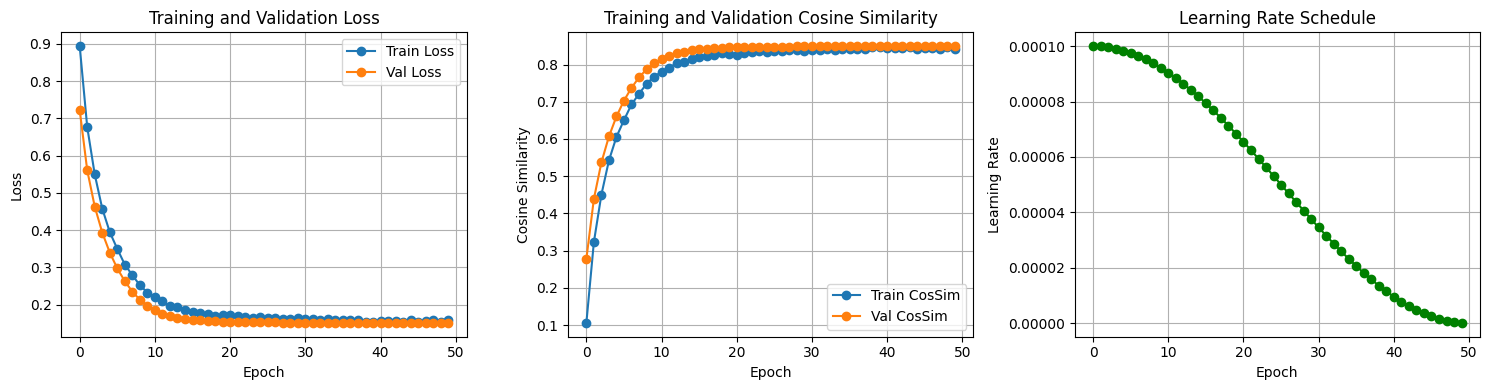


Training complete!
Best model saved to: best_clip_offset_mlp.pth

INFERENCE EXAMPLE
Generated embedding shape: torch.Size([1, 512])
Embedding norm: 1.0000

This embedding can now be used as conditioning for your diffusion model!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

def cosine_similarity_loss(predictions, targets):
    """
    Loss based on cosine similarity between predicted and target embeddings.
    L = 1 - cos(E_pred, E_img)
    """
    # targets has shape (batch_size, 1, embed_dim), squeeze it
    targets = targets.squeeze(1)

    # Compute cosine similarity
    cosine_sim = F.cosine_similarity(predictions, targets, dim=1)

    # Convert to loss (1 = no similarity, 0 = perfect similarity)
    loss = 1 - cosine_sim

    return loss.mean()


def train_clip_mlp(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    lr=1e-4,
    weight_decay=0.01,
    device='cuda',
    save_path='best_clip_offset_mlp.pth',
    patience=10
):
    """
    Train the CLIP offset MLP using cosine similarity loss.
    Model predicts: E_pred = E_base + MLP(x_input)
    Loss: L = 1 - cos(E_pred, E_img)

    Args:
        model: CLIPOffsetMLP model instance
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of training epochs
        lr: Learning rate
        weight_decay: Weight decay for AdamW optimizer
        device: Device to train on ('cuda' or 'cpu')
        save_path: Path to save the best model
        patience: Early stopping patience (epochs without improvement)

    Returns:
        model: Trained model
        history: Dictionary containing training history
    """
    model = model.to(device)

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Training history
    history = {
        'train_loss': [],
        'train_cos_sim': [],
        'val_loss': [],
        'val_cos_sim': [],
        'lr': []
    }

    best_val_loss = float('inf')
    patience_counter = 0

    print(f"Starting training on {device}...")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print("-" * 80)

    for epoch in range(num_epochs):
        # ============= TRAINING =============
        model.train()
        train_loss = 0
        train_cos_sim = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for string_embeds, cat_inputs, base_text_embed, target_images in train_pbar:
            # Move to device
            string_embeds = string_embeds.to(device)
            cat_inputs = cat_inputs.to(device)
            base_text_embed = base_text_embed.to(device)
            target_images = target_images.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass: E_pred = E_base + MLP(x_input)
            predictions = model(string_embeds, cat_inputs, base_text_embed)

            # Compute loss: L = 1 - cos(E_pred, E_img)
            loss = cosine_similarity_loss(predictions, target_images)

            # Backward pass
            loss.backward()

            # Gradient clipping (optional but helpful)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            optimizer.step()

            # Track metrics
            train_loss += loss.item()

            with torch.no_grad():
                cos_sim = F.cosine_similarity(predictions, target_images.squeeze(1), dim=1)
                train_cos_sim += cos_sim.mean().item()

            # Update progress bar
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'cos_sim': f'{cos_sim.mean().item():.4f}'
            })

        train_loss /= len(train_loader)
        train_cos_sim /= len(train_loader)

        # ============= VALIDATION =============
        model.eval()
        val_loss = 0
        val_cos_sim = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ")
            for string_embeds, cat_inputs, base_text_embed, target_images in val_pbar:
                # Move to device
                string_embeds = string_embeds.to(device)
                cat_inputs = cat_inputs.to(device)
                base_text_embed = base_text_embed.to(device)
                target_images = target_images.to(device)

                # Forward pass
                predictions = model(string_embeds, cat_inputs, base_text_embed)

                # Compute loss
                loss = cosine_similarity_loss(predictions, target_images)

                # Track metrics
                val_loss += loss.item()
                cos_sim = F.cosine_similarity(predictions, target_images.squeeze(1), dim=1)
                val_cos_sim += cos_sim.mean().item()

                # Update progress bar
                val_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'cos_sim': f'{cos_sim.mean().item():.4f}'
                })

        val_loss /= len(val_loader)
        val_cos_sim /= len(val_loader)

        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()

        # Store history
        history['train_loss'].append(train_loss)
        history['train_cos_sim'].append(train_cos_sim)
        history['val_loss'].append(val_loss)
        history['val_cos_sim'].append(val_cos_sim)
        history['lr'].append(current_lr)

        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train CosSim: {train_cos_sim:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val CosSim:   {val_cos_sim:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_cos_sim': val_cos_sim,
            }, save_path)
            print(f"  ✓ Saved best model (val_loss: {val_loss:.4f}, val_cos_sim: {val_cos_sim:.4f})")
        else:
            patience_counter += 1
            print(f"  No improvement for {patience_counter} epoch(s)")

        print("-" * 80)

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    # Load best model
    print(f"\nLoading best model from {save_path}")
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model - Epoch: {checkpoint['epoch']+1}, Val Loss: {checkpoint['val_loss']:.4f}, Val CosSim: {checkpoint['val_cos_sim']:.4f}")

    return model, history


def plot_training_history(history):
    """
    Plot training and validation metrics.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Loss plot
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Cosine similarity plot
    axes[1].plot(history['train_cos_sim'], label='Train CosSim', marker='o')
    axes[1].plot(history['val_cos_sim'], label='Val CosSim', marker='o')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Cosine Similarity')
    axes[1].set_title('Training and Validation Cosine Similarity')
    axes[1].legend()
    axes[1].grid(True)

    # Learning rate plot
    axes[2].plot(history['lr'], marker='o', color='green')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


# ============= COMPLETE EXAMPLE USAGE =============
if __name__ == "__main__":
    import clip
    from torch.utils.data import DataLoader

    # Setup
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}\n")

    # Load CLIP model
    print("Loading CLIP model...")
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    clip_model.eval()

    # Load dataset (using the CharacterDataset from previous artifact)
    print("\nLoading dataset from CSV...")
    csv_file = "characters.csv"
    image_dir = "character_images/"

    # Initialize model
    print("\nInitializing CLIP Offset MLP model...")

    # Get number of categories from dataset
    num_categories = dataset.get_num_categories()  # e.g., [7, 7, 5, 3]

    model = CLIPOffsetMLP(
        clip_dim=512,  # ViT-B/32 uses 512, ViT-L/14 uses 768
        string_embed_dim=512,
        num_categories_per_attr=num_categories,
        hidden_dims=[1024, 1024, 512],
        normalize_inputs=True
    )

    # Train the model
    print("\nStarting training...\n")
    trained_model, history = train_clip_mlp(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=50,
        lr=1e-4,
        weight_decay=0.01,
        device=device,
        save_path='best_clip_offset_mlp.pth',
        patience=10
    )

    # Plot training history
    print("\nPlotting training history...")
    plot_training_history(history)

    print("\nTraining complete!")
    print(f"Best model saved to: best_clip_offset_mlp.pth")

    # Example inference
    print("\n" + "="*80)
    print("INFERENCE EXAMPLE")
    print("="*80)
    trained_model.eval()
    with torch.no_grad():
        # Get first sample from validation set
        string_embeds, cat_inputs, base_embed, _ = next(iter(val_loader))

        # Move to device and take first sample
        string_embeds = string_embeds[:1].to(device)
        cat_inputs = cat_inputs[:1].to(device)
        base_embed = base_embed[:1].to(device)

        # Inference: E* = E_text + E_offset
        embedding_star = trained_model.inference(string_embeds, cat_inputs, base_embed)

        print(f"Generated embedding shape: {embedding_star.shape}")
        print(f"Embedding norm: {embedding_star.norm().item():.4f}")

In [ ]:
def test_inference(model_path, device='cpu'):  # Changed default to 'cpu'
    """Quick inference test"""
    # Load model
    model = CLIPOffsetMLP(
        clip_dim=512,
        string_embed_dim=512,
        num_categories_per_attr=[6, 7, 5, 5],
        hidden_dims=[1024, 1024, 512]
    )
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Create dummy inputs
    batch_size = 2
    string_embeds = torch.randn(batch_size, 3, 512).to(device)
    categorical_inputs = torch.tensor([[0, 1, 2, 3], [5, 6, 4, 2]]).to(device)
    base_text_embed = torch.randn(1, 512).to(device)

    # Run inference
    with torch.no_grad():
        output = model(string_embeds, categorical_inputs, base_text_embed)

    print(f"✓ Inference successful!")
    print(f"  Output shape: {output.shape}")
    print(f"  Output norm: {output.norm(dim=1).mean():.4f}")
    return output

# Run test
output = test_inference('best_clip_offset_mlp.pth')


Model Architecture:
  Input dimensions:
    - One-hot vectors: 23
    - Text embeddings: 1536 (3 × 512)
    - Total input: 1559
  Hidden layers: [1024, 1024, 512]
  Output dimension: 512
  Normalize inputs: True
  Dropout: 0.1

✓ Inference successful!
  Output shape: torch.Size([2, 512])
  Output norm: 1.0000


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from PIL import Image
import clip
from pathlib import Path


def compute_similarity_metrics(model, dataset, device, num_samples=None):
    """
    Compute detailed similarity metrics between predicted and target embeddings

    Returns:
        results: Dictionary with per-sample cosine similarities and character names
    """
    model.eval()

    if num_samples is None:
        num_samples = len(dataset)

    results = {
        'character_names': [],
        'cosine_similarities': [],
        'predicted_embeddings': [],
        'target_embeddings': []
    }

    with torch.no_grad():
        for idx in range(min(num_samples, len(dataset))):
            # Get data
            string_embeds, cat_inputs, base_embed, target_image = dataset[idx]

            # Add batch dimension
            string_embeds = string_embeds.unsqueeze(0).to(device)
            cat_inputs = cat_inputs.unsqueeze(0).to(device)
            base_embed = base_embed.to(device)
            target_image = target_image.to(device)

            # Squeeze if needed
            if target_image.dim() == 3:
                target_image = target_image.squeeze(1)

            # Predict
            pred_embedding = model(string_embeds, cat_inputs, base_embed)

            # Compute cosine similarity
            cos_sim = F.cosine_similarity(pred_embedding, target_image, dim=1)

            # Store results
            results['character_names'].append(dataset.dataset.get_character_name(dataset.indices[idx]))
            results['cosine_similarities'].append(cos_sim.item())
            results['predicted_embeddings'].append(pred_embedding.cpu().numpy())
            results['target_embeddings'].append(target_image.cpu().numpy())

    return results


def plot_similarity_distribution(results, save_path='similarity_distribution.png'):
    """Plot distribution of cosine similarities"""
    similarities = results['cosine_similarities']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Histogram
    ax1.hist(similarities, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    ax1.axvline(np.mean(similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(similarities):.3f}')
    ax1.axvline(np.median(similarities), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(similarities):.3f}')
    ax1.set_xlabel('Cosine Similarity', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Distribution of Cosine Similarities', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Box plot
    ax2.boxplot(similarities, vert=True)
    ax2.set_ylabel('Cosine Similarity', fontsize=12)
    ax2.set_title('Cosine Similarity Box Plot', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✓ Saved similarity distribution to {save_path}")


def plot_top_and_worst(results, n=5, save_path='top_worst_predictions.png'):
    """Show top N and worst N predictions"""
    similarities = np.array(results['cosine_similarities'])
    names = results['character_names']

    # Get indices
    top_indices = np.argsort(similarities)[-n:][::-1]
    worst_indices = np.argsort(similarities)[:n]

    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Top predictions
    top_names = [names[i] for i in top_indices]
    top_sims = [similarities[i] for i in top_indices]
    axes[0].barh(range(n), top_sims, color='green', alpha=0.7)
    axes[0].set_yticks(range(n))
    axes[0].set_yticklabels(top_names)
    axes[0].set_xlabel('Cosine Similarity', fontsize=12)
    axes[0].set_title(f'Top {n} Predictions', fontsize=14, fontweight='bold')
    axes[0].set_xlim([0, 1])
    for i, v in enumerate(top_sims):
        axes[0].text(v + 0.01, i, f'{v:.3f}', va='center')

    # Worst predictions
    worst_names = [names[i] for i in worst_indices]
    worst_sims = [similarities[i] for i in worst_indices]
    axes[1].barh(range(n), worst_sims, color='red', alpha=0.7)
    axes[1].set_yticks(range(n))
    axes[1].set_yticklabels(worst_names)
    axes[1].set_xlabel('Cosine Similarity', fontsize=12)
    axes[1].set_title(f'Worst {n} Predictions', fontsize=14, fontweight='bold')
    axes[1].set_xlim([0, 1])
    for i, v in enumerate(worst_sims):
        axes[1].text(v + 0.01, i, f'{v:.3f}', va='center')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✓ Saved top/worst predictions to {save_path}")


def visualize_embeddings_2d(results, method='pca', save_path='embeddings_2d.png'):
    """
    Visualize embeddings in 2D using PCA or t-SNE

    Args:
        results: Results dictionary from compute_similarity_metrics
        method: 'pca' or 'tsne'
        save_path: Path to save the plot
    """
    # Stack embeddings
    pred_embeds = np.vstack(results['predicted_embeddings'])
    target_embeds = np.vstack(results['target_embeddings'])

    # Combine for dimensionality reduction
    all_embeds = np.vstack([pred_embeds, target_embeds])

    # Reduce dimensionality
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        embeds_2d = reducer.fit_transform(all_embeds)
        title_suffix = f'(Explained Var: {sum(reducer.explained_variance_ratio_):.1%})'
    else:  # tsne
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_embeds)//2))
        embeds_2d = reducer.fit_transform(all_embeds)
        title_suffix = ''

    # Split back
    n_samples = len(pred_embeds)
    pred_2d = embeds_2d[:n_samples]
    target_2d = embeds_2d[n_samples:]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot targets (actual images)
    scatter1 = ax.scatter(target_2d[:, 0], target_2d[:, 1],
                         c='blue', s=100, alpha=0.6, marker='o',
                         label='Target (Real Images)', edgecolors='black', linewidths=1)

    # Plot predictions
    scatter2 = ax.scatter(pred_2d[:, 0], pred_2d[:, 1],
                         c='red', s=100, alpha=0.6, marker='^',
                         label='Predicted (MLP Output)', edgecolors='black', linewidths=1)

    # Draw lines connecting corresponding points
    for i in range(n_samples):
        ax.plot([pred_2d[i, 0], target_2d[i, 0]],
               [pred_2d[i, 1], target_2d[i, 1]],
               'gray', alpha=0.3, linewidth=0.5)

    # Annotate some points
    n_annotate = min(10, n_samples)
    for i in range(n_annotate):
        ax.annotate(results['character_names'][i],
                   (target_2d[i, 0], target_2d[i, 1]),
                   fontsize=8, alpha=0.7)

    ax.set_xlabel(f'Component 1', fontsize=12)
    ax.set_ylabel(f'Component 2', fontsize=12)
    ax.set_title(f'CLIP Embedding Space Visualization ({method.upper()}) {title_suffix}',
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✓ Saved 2D embedding visualization to {save_path}")


def test_single_character(model, dataset, idx, clip_model, device, k=5):
    """
    Test a single character and find its nearest neighbors in CLIP space

    Args:
        model: Trained MLP model
        dataset: Dataset object
        idx: Index of character to test
        clip_model: CLIP model for computing image similarities
        device: torch device
        k: Number of nearest neighbors to find
    """
    model.eval()

    # Get character info
    if hasattr(dataset, 'indices'):
        actual_idx = dataset.indices[idx]
        char_name = dataset.dataset.get_character_name(actual_idx)
        char_data = dataset.dataset.get_raw_data(actual_idx)
        img_path = dataset.dataset.get_image_path(actual_idx)
    else:
        char_name = dataset.get_character_name(idx)
        char_data = dataset.get_raw_data(idx)
        img_path = dataset.get_image_path(idx)

    print("\n" + "="*70)
    print(f"TESTING CHARACTER: {char_name}")
    print("="*70)
    print(f"Image path: {img_path}")
    print(f"\nCharacter attributes:")
    for key, value in char_data.items():
        if key != 'image_path':
            print(f"  {key}: {value}")

    # Get data
    string_embeds, cat_inputs, base_embed, target_image = dataset[idx]

    # Add batch dimension
    string_embeds = string_embeds.unsqueeze(0).to(device)
    cat_inputs = cat_inputs.unsqueeze(0).to(device)
    base_embed = base_embed.to(device)
    target_image = target_image.to(device)

    if target_image.dim() == 3:
        target_image = target_image.squeeze(1)

    # Predict
    with torch.no_grad():
        pred_embedding = model(string_embeds, cat_inputs, base_embed)

    # Compute similarity
    cos_sim = F.cosine_similarity(pred_embedding, target_image, dim=1)

    print(f"\n{'='*70}")
    print(f"RESULTS:")
    print(f"{'='*70}")
    print(f"Cosine Similarity: {cos_sim.item():.4f}")
    print(f"Embedding Distance (L2): {torch.dist(pred_embedding, target_image).item():.4f}")

    # Find nearest neighbors in the dataset
    print(f"\nFinding {k} nearest neighbors to PREDICTED embedding...")
    all_similarities = []

    with torch.no_grad():
        for i in range(len(dataset)):
            _, _, _, other_target = dataset[i]
            other_target = other_target.to(device)
            if other_target.dim() == 3:
                other_target = other_target.squeeze(1)

            sim = F.cosine_similarity(pred_embedding, other_target, dim=1)
            all_similarities.append(sim.item())

    # Get top k
    top_k_indices = np.argsort(all_similarities)[-k:][::-1]

    print(f"\nTop {k} most similar characters (based on predicted embedding):")
    for rank, i in enumerate(top_k_indices, 1):
        if hasattr(dataset, 'indices'):
            actual_i = dataset.indices[i]
            name = dataset.dataset.get_character_name(actual_i)
        else:
            name = dataset.get_character_name(i)
        print(f"  {rank}. {name}: {all_similarities[i]:.4f}")

    print("="*70 + "\n")

    return {
        'character_name': char_name,
        'cosine_similarity': cos_sim.item(),
        'predicted_embedding': pred_embedding.cpu().numpy(),
        'target_embedding': target_image.cpu().numpy(),
        'nearest_neighbors': [(dataset.dataset.get_character_name(dataset.indices[i]) if hasattr(dataset, 'indices') else dataset.get_character_name(i),
                              all_similarities[i]) for i in top_k_indices]
    }


def generate_text_to_image_retrieval(model, dataset, clip_model, device,
                                     test_descriptions, k=5):
    """
    Test text-to-image retrieval: given a text description, find most similar images

    Args:
        model: Trained MLP model
        dataset: Dataset object
        clip_model: CLIP model
        device: torch device
        test_descriptions: List of text descriptions to test
        k: Number of top results to return
    """
    model.eval()

    # Get all target image embeddings from dataset
    all_targets = []
    all_names = []

    with torch.no_grad():
        for i in range(len(dataset)):
            _, _, _, target = dataset[i]
            all_targets.append(target.squeeze())
            if hasattr(dataset, 'indices'):
                all_names.append(dataset.dataset.get_character_name(dataset.indices[i]))
            else:
                all_names.append(dataset.get_character_name(i))

    all_targets = torch.stack(all_targets).to(device)

    print("\n" + "="*70)
    print("TEXT-TO-IMAGE RETRIEVAL TEST")
    print("="*70)

    for desc in test_descriptions:
        print(f"\nQuery: '{desc}'")
        print("-" * 70)

        # Encode text with CLIP
        with torch.no_grad():
            text_tokens = clip.tokenize([desc]).to(device)
            text_embed = clip_model.encode_text(text_tokens)
            text_embed = text_embed / text_embed.norm(dim=-1, keepdim=True)

        # Compute similarities with all images
        similarities = F.cosine_similarity(text_embed, all_targets, dim=1)

        # Get top k
        top_k_indices = torch.argsort(similarities, descending=True)[:k]

        print(f"Top {k} matches:")
        for rank, idx in enumerate(top_k_indices, 1):
            print(f"  {rank}. {all_names[idx]}: {similarities[idx].item():.4f}")

    print("="*70 + "\n")


def comprehensive_evaluation(model, val_dataset, clip_model, device, save_dir='./evaluation'):
    """
    Run comprehensive evaluation and generate all visualizations
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    print("\n" + "="*70)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*70 + "\n")

    # 1. Compute similarity metrics
    print("Computing similarity metrics...")
    results = compute_similarity_metrics(model, val_dataset, device)

    # Print summary statistics
    sims = results['cosine_similarities']
    print(f"\nSummary Statistics:")
    print(f"  Mean cosine similarity: {np.mean(sims):.4f}")
    print(f"  Median cosine similarity: {np.median(sims):.4f}")
    print(f"  Std deviation: {np.std(sims):.4f}")
    print(f"  Min: {np.min(sims):.4f}")
    print(f"  Max: {np.max(sims):.4f}")

    # 2. Plot similarity distribution
    print("\nGenerating similarity distribution plot...")
    plot_similarity_distribution(results, save_path=save_dir / 'similarity_distribution.png')

    # 3. Plot top and worst predictions
    print("Generating top/worst predictions plot...")
    plot_top_and_worst(results, n=5, save_path=save_dir / 'top_worst_predictions.png')

    # 4. Visualize embeddings in 2D (PCA)
    print("Generating PCA visualization...")
    visualize_embeddings_2d(results, method='pca', save_path=save_dir / 'embeddings_pca.png')

    # 5. Visualize embeddings in 2D (t-SNE)
    print("Generating t-SNE visualization...")
    visualize_embeddings_2d(results, method='tsne', save_path=save_dir / 'embeddings_tsne.png')

    # 6. Test a few random characters
    print("\nTesting random characters...")
    num_tests = min(3, len(val_dataset))
    for i in range(num_tests):
        idx = np.random.randint(0, len(val_dataset))
        test_single_character(model, val_dataset, idx, clip_model, device, k=5)

    print("="*70)
    print(f"✓ Evaluation complete! Results saved to {save_dir}")
    print("="*70 + "\n")

    return results


# Example usage
if __name__ == "__main__":
    """
    Example
    """
    import clip

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load CLIP
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    clip_model.eval()


    # Initialize model architecture (must match training)
    model = CLIPOffsetMLP(
        clip_dim=512,
        string_embed_dim=512,
        num_categories_per_attr=[6, 7, 5, 5],
        num_text_attrs=3,
        hidden_dims=[1024, 1024, 512],
        normalize_inputs=True,
        dropout=0.1
    ).to(device)

    # Load trained weights
    model.load_state_dict(torch.load('./checkpoints/best_model_weights.pth'))
    model.eval()
    # Run comprehensive evaluation
    results = comprehensive_evaluation(model, val_dataset, clip_model, device, save_dir='./evaluation')

    # Test specific character
    test_single_character(model, val_dataset, idx=0, clip_model=clip_model, device=device, k=5)

    # Test text-to-image retrieval
    test_descriptions = [
        "A pyro character from Liyue",
        "An electro polearm user",
        "A character from Mondstadt"
    ]
    generate_text_to_image_retrieval(model, val_dataset, clip_model, device, test_descriptions, k=5)



Model Architecture:
  Input dimensions:
    - One-hot vectors: 23
    - Text embeddings: 1536 (3 × 512)
    - Total input: 1559
  Hidden layers: [1024, 1024, 512]
  Output dimension: 512
  Normalize inputs: True
  Dropout: 0.1


COMPREHENSIVE MODEL EVALUATION

Computing similarity metrics...

Summary Statistics:
  Mean cosine similarity: 0.8494
  Median cosine similarity: 0.8548
  Std deviation: 0.0292
  Min: 0.7857
  Max: 0.8893

Generating similarity distribution plot...
✓ Saved similarity distribution to evaluation/similarity_distribution.png
Generating top/worst predictions plot...
✓ Saved top/worst predictions to evaluation/top_worst_predictions.png
Generating PCA visualization...
✓ Saved 2D embedding visualization to evaluation/embeddings_pca.png
Generating t-SNE visualization...
✓ Saved 2D embedding visualization to evaluation/embeddings_tsne.png

Testing random characters...

TESTING CHARACTER: Shenhe
Image path: /content/drive/MyDrive/characters/Shenhe.png

Character attribut